In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install seed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#imports
import numpy as np
from math import sqrt
from numpy import concatenate

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

from matplotlib import pyplot
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat


import keras.utils
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.optimizers import Adam

import tensorflow as tf
import seaborn as sn
import seed
import os
tf.get_logger().setLevel('ERROR')

from sklearn.preprocessing import MinMaxScaler

In [ ]:
"""
method to create lagged features

data - data
to_keep - number of lagged_features
to_remove - number of days to remove

"""
def create_lagged_features(data, to_keep=1, to_remove=1):
    variables = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    columns, names = list(), list()
    
    for i in range(to_keep, 0, -1):
        columns.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(variables)]

    for i in range(0, to_remove):
        columns.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(variables)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(variables)]
            
    #put it all together
    final = concat(columns, axis=1)
    final.columns = names
    
    #drop rows with NaN values
    final.dropna(inplace=True)
        
    return final

In [ ]:
# read data 
input_data = pd.read_csv("/content/drive/MyDrive/CS5344 Group9/BTC Price Pred Code/final_day_lag_days_1.csv", sep=",")
# features = ["pos_pol", "neg_pol", "Tweet_vol", "Close", "Pct_change"]
features = ['Pct_change', 'Close', 'pos_pol', 'neg_pol', 'Tweet_vol']
input_data = input_data.set_index("DateTime")
input_data.head(5)

,Close,Volume_(BTC),Weighted_Price,neg_pol,neu_pol,pos_pol,compound,dt,Tweet_vol
DateTime,,,,,,,,,
2018-08-30 00:00:00+00:00,7027.99,5.484323,6979.227679,0.043827,0.825543,0.130654,0.230801,2018-08-30 17:27:42.953691904+00:00,557.0
2018-08-31 00:00:00+00:00,7187.23,3.694477,7097.021073,0.039833,0.847201,0.112971,0.196773,2018-08-31 12:35:16.275116032+00:00,902.0
2018-09-01 00:00:00+00:00,7275.00,2.830380,7233.487967,0.036618,0.846208,0.117174,0.208065,2018-09-01 12:10:04.422492416+00:00,818.0
2018-09-02 00:00:00+00:00,7301.01,2.130486,7260.380171,0.047145,0.837654,0.115190,0.163561,2018-09-02 12:19:51.883408128+00:00,860.0
2018-09-03 00:00:00+00:00,7357.07,3.392408,7317.186602,0.045408,0.839805,0.114770,0.181093,2018-09-03 12:10:22.157143040+00:00,980.0


In [ ]:
input_data = input_data.groupby('DateTime').agg(lambda x: x.mean())

/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


In [ ]:
input_data["Pct_change"] = (input_data["Close"] > input_data["Close"].shift(1)).astype(int)

add_RSI = False
add_longMAvg = False
add_shortMAvg = False

def rsi(data, period: int = 14):
    
    delta = data["Close"].diff()

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    gain = up.ewm(com=(period - 1), min_periods=period).mean()
    loss = down.abs().ewm(com=(period - 1), min_periods=period).mean()

    RS = gain / loss
    return 100 - (100 / (1 + RS))

if(add_RSI):
    #calcualte RSI
    RSI = 14
    input_data['RSI'] = rsi(input_data, RSI)
    df = input_data.iloc[RSI:]

#calculate moving averages
if(add_shortMAvg):
    short_window = 9
    input_data['short_mavg'] = input_data.rolling(window=short_window)["Close"].mean()
    
if(add_longMAvg):
    long_window = 21
    input_data["long_mavg"] = input_data.rolling(window=long_window)["Close"].mean()
    
if(add_longMAvg):
    input_data = input_data.iloc[long_window:]
elif(add_RSI):
    input_data = input_data.iloc[RSI:]
elif(add_shortMAvg):
    input_data = input_data.iloc[short_window:]


In [ ]:
if(add_RSI):
    features.append("RSI")
    
if(add_longMAvg):
    features.append("long_mavg")
    
if(add_shortMAvg):
    features.append("short_mavg")

input_data = input_data[features]


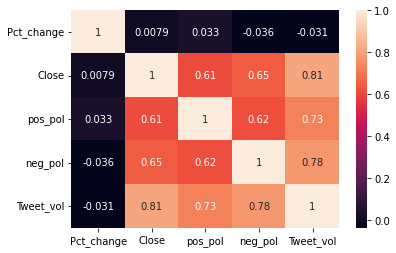

In [ ]:
import seaborn as sn

sn.heatmap(input_data.corr(), annot=True)
plt.show()

In [ ]:
#number of previous records to consider for every example
n_lag = 7
#number of features
n_features = len(features)
#calculate total_features
total_features = n_lag*n_features

if(total_features == 0):
    total_features = n_features

In [ ]:
df_copy = input_data.copy()

In [ ]:
#add lagged data to records
data_with_lagged = create_lagged_features(df_copy, n_lag, 1)
data_with_lagged = data_with_lagged.reset_index()
data_with_lagged = data_with_lagged.drop(['DateTime'], axis=1)
data_with_lagged

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
0,0.0,7027.99,0.130654,0.043827,557.0,1.0,7187.23,0.112971,0.039833,902.0,...,0.0,6435.58,0.121899,0.049716,1027.0,0,6416.13,0.121202,0.032114,1012.0
1,1.0,7187.23,0.112971,0.039833,902.0,1.0,7275.00,0.117174,0.036618,818.0,...,0.0,6416.13,0.121202,0.032114,1012.0,0,6178.21,0.123376,0.043544,800.0
2,1.0,7275.00,0.117174,0.036618,818.0,1.0,7301.01,0.115190,0.047145,860.0,...,0.0,6178.21,0.123376,0.043544,800.0,1,6363.43,0.120444,0.045632,787.0
3,1.0,7301.01,0.115190,0.047145,860.0,1.0,7357.07,0.114770,0.045408,980.0,...,1.0,6363.43,0.120444,0.045632,787.0,0,6294.42,0.109227,0.045101,876.0
4,1.0,7357.07,0.114770,0.045408,980.0,0.0,6927.90,0.118960,0.039350,987.0,...,0.0,6294.42,0.109227,0.045101,876.0,1,6311.43,0.120255,0.040090,896.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,0.0,8746.45,0.179880,0.064749,63453.0,0.0,8647.04,0.179688,0.067637,57852.0,...,0.0,8123.89,0.172602,0.067930,59746.0,0,8085.36,0.181439,0.066980,62924.0
440,0.0,8647.04,0.179688,0.067637,57852.0,0.0,8503.74,0.179675,0.069204,57564.0,...,0.0,8085.36,0.181439,0.066980,62924.0,0,7618.17,0.195808,0.060034,61536.0
441,0.0,8503.74,0.179675,0.069204,57564.0,0.0,8469.20,0.176000,0.070255,56993.0,...,0.0,7618.17,0.195808,0.060034,61536.0,0,7272.99,0.184078,0.071387,69663.0
442,0.0,8469.20,0.176000,0.070255,56993.0,1.0,8545.36,0.178359,0.070595,46589.0,...,0.0,7272.99,0.184078,0.071387,69663.0,1,7308.09,0.172377,0.079548,74716.0


In [ ]:
# shuffle data 
np.random.seed(1)
#shuffle times 
shuffle_times = 3;
for j in range(0, shuffle_times+1):
    data_with_lagged = shuffle(data_with_lagged)

In [ ]:
# divide data 
train_ratio = 0.85
data_len = len(data_with_lagged)
train_size = int(data_len*train_ratio)
train = data_with_lagged.iloc[:train_size]
test = data_with_lagged.iloc[train_size:]
train.shape

(377, 40)

In [ ]:
# prepare label 
train_y = train["var1(t)"].values
test_y = test["var1(t)"].values

train_y = train_y.reshape(len(train_y), 1)
# train_y = keras.utils.to_categorical(train_y, 2)
test_y = test_y.reshape(len(test_y), 1)

train_y.shape

(377, 1)

In [ ]:
#normalise features
xscaler = MinMaxScaler(feature_range=(0, 1))
train = xscaler.fit_transform(train)
test = xscaler.transform(test)

In [ ]:
#prepare data
train_labels = train_y
test_labels = test_y

In [ ]:
#remove the last set of values(data of time to be predicted)
train = train[:, :total_features]
test = test[:, :total_features]

In [ ]:
#keep only prices array
train_X, train_y = train[:, :total_features], train_y[:, -1]
test_X, test_y = test[:, :total_features], test_y[:, -1]
train_X.shape

(377, 35)

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))

In [ ]:
# similar to one hot 
train_y = keras.utils.to_categorical(train_y, 2)

In [ ]:
# split data 
print("*"*100)
print("Train size: ", train_X.shape)
print("Test size: ", test_X.shape)

****************************************************************************************************
Train size:  (377, 7, 5)
Test size:  (67, 7, 5)


In [ ]:
# define model 
np.random.seed(1) 
tf.random.set_seed(1)

# design network
model = Sequential()
neurons = 64
epochs = 10000
dropout = 0.25
batch_size = 80
activ_func = "linear"

from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization, GRU, CuDNNLSTM, Activation

model.add(Bidirectional(
  CuDNNLSTM(neurons, return_sequences=True),
  input_shape=(train_X.shape[1], train_X.shape[2])
))
model.add(Dropout(rate=dropout))

model.add(Bidirectional(
  CuDNNLSTM((neurons * 2), return_sequences=True)
))
model.add(Dropout(rate=dropout))

model.add(Bidirectional(
  CuDNNLSTM(neurons, return_sequences=False)
))


model.add(Dense(2, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# early stopping callback
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience =20)

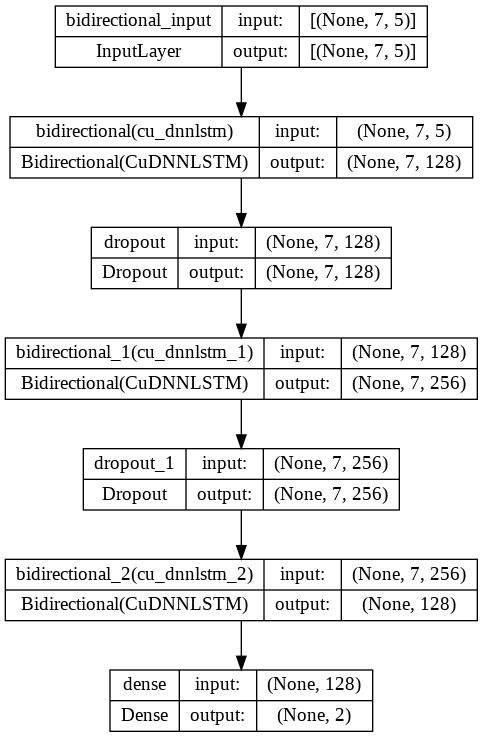

In [ ]:
model_file = 'model.png'
tf.keras.utils.plot_model(model, to_file=model_file, show_shapes=True)

In [ ]:
# fit network
history = model.fit(
    train_X, 
    train_y, 
    epochs=epochs, 
    batch_size=batch_size, 
    verbose=2, 
    shuffle=True,
    validation_split=0.2, callbacks=[callback])

Epoch 1/10000
4/4 - 9s - loss: 0.7064 - accuracy: 0.4983 - val_loss: 0.6887 - val_accuracy: 0.6447 - 9s/epoch - 2s/step
Epoch 2/10000
4/4 - 0s - loss: 0.6926 - accuracy: 0.5183 - val_loss: 0.7144 - val_accuracy: 0.3553 - 62ms/epoch - 15ms/step
Epoch 3/10000
4/4 - 0s - loss: 0.6957 - accuracy: 0.4983 - val_loss: 0.7183 - val_accuracy: 0.3553 - 56ms/epoch - 14ms/step
Epoch 4/10000
4/4 - 0s - loss: 0.6953 - accuracy: 0.5183 - val_loss: 0.6930 - val_accuracy: 0.4605 - 59ms/epoch - 15ms/step
Epoch 5/10000
4/4 - 0s - loss: 0.6920 - accuracy: 0.5216 - val_loss: 0.6864 - val_accuracy: 0.6447 - 61ms/epoch - 15ms/step
Epoch 6/10000
4/4 - 0s - loss: 0.6909 - accuracy: 0.5282 - val_loss: 0.6864 - val_accuracy: 0.6447 - 67ms/epoch - 17ms/step
Epoch 7/10000
4/4 - 0s - loss: 0.6906 - accuracy: 0.5415 - val_loss: 0.6944 - val_accuracy: 0.4342 - 61ms/epoch - 15ms/step
Epoch 8/10000
4/4 - 0s - loss: 0.6902 - accuracy: 0.5349 - val_loss: 0.6936 - val_accuracy: 0.4474 - 60ms/epoch - 15ms/step
Epoch 9/1000

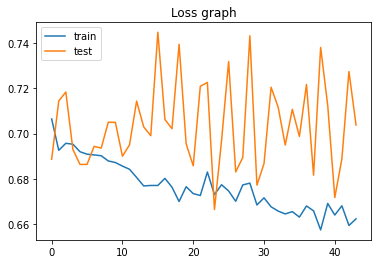

In [ ]:
#plot loss graph
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Loss graph")
plt.show()

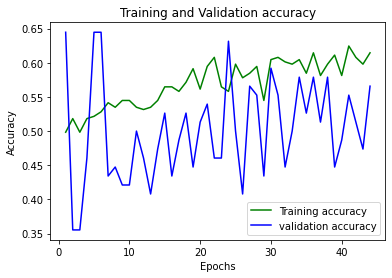

In [ ]:
#plot training and validation accuracy
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,len(loss_val) + 1)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#reshape
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))

#predict values for test data
pred = model.predict(test_X)

#reshape again
test_X = test_X.reshape((test_X.shape[0], n_lag* n_features,))

3/3 [==============================] - 1s 20ms/step


In [ ]:
#change back from categorical
pred = np.argmax(pred, axis=1)

In [ ]:
#calculate accuracy
prices = pd.DataFrame()
prices["Actual"] = test_y
prices["Predicted"] = pred

prices["Correct"] = (prices["Actual"] - prices["Predicted"]) == 0
incorrect = prices.loc[prices['Correct'] == False]
incorrect_len = len(incorrect)
prices_len = len(prices)

print("Accuracy = ",((prices_len-incorrect_len)/prices_len))
prices

Accuracy =  0.5970149253731343


,Actual,Predicted,Correct
0,1,0,False
1,1,1,True
2,0,1,False
3,0,1,False
4,1,1,True
...,...,...,...
62,1,1,True
63,0,0,True
64,1,1,True
65,0,1,False


In [ ]:
#Try printing the confusion matrix
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(prices["Actual"], prices["Predicted"])
print('Confusion Matrix : \n', CM)  
# TN = CM[0][0]
# FN = CM[1][0]
# TP = CM[1][1]
# FP = CM[0][1]
# print(f"TN: {TN}")
# print(f"FN: {FN}")
# print(f"TP: {TP}")
# print(f"FP: {FP}")

Confusion Matrix : 
 [[15 20]
 [ 7 25]]


CNN MODEL

In [ ]:
from keras.layers import Convolution1D, Conv1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense

np.random.seed(1) 
tf.random.set_seed(1)

# design network
model = Sequential()
neurons = 32
epochs = 10000
dropout = 0.25
batch_size = 50
layers = 3
activ_func = "linear"

#add first layer
model.add(Conv1D(neurons, kernel_size=2, padding='same', input_shape=(train_X.shape[1], train_X.shape[2]), activation=activ_func))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Dropout(dropout))

#add the other layers
for i in range(1, layers):
    model.add(Conv1D(neurons, kernel_size=2, padding='same', activation=activ_func))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Dropout(dropout))


#flatten and add a dense layer and to output the prediction
model.add(Flatten())
model.add(Dense(2, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience =20)

# fit network
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False,validation_split=0.2, callbacks=[callback])

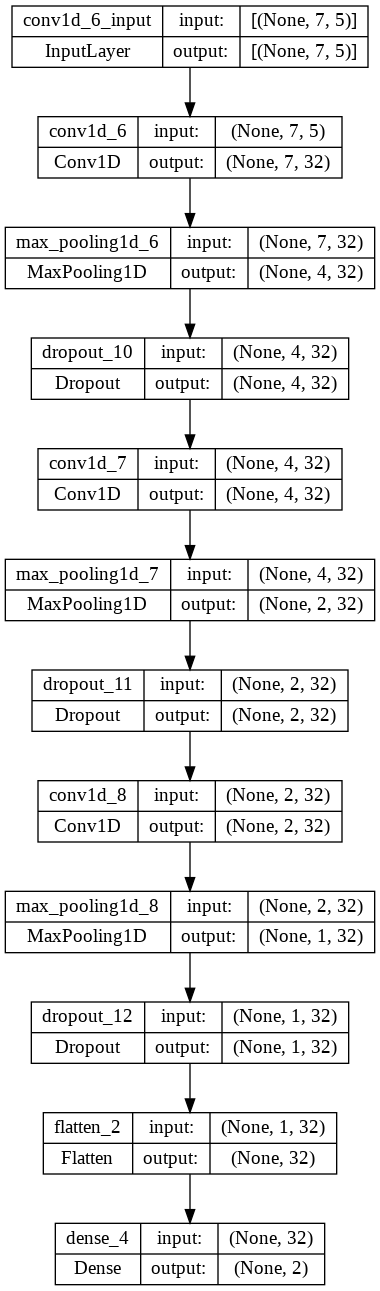

In [ ]:
dot_img_file = 'model.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
#callback
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience =50)

# fit network
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=True,validation_split=0.2, callbacks=[callback])

Epoch 1/10000
7/7 - 0s - loss: 0.6766 - accuracy: 0.5615 - val_loss: 0.7262 - val_accuracy: 0.4605 - 89ms/epoch - 13ms/step
Epoch 2/10000
7/7 - 0s - loss: 0.6926 - accuracy: 0.5382 - val_loss: 0.7006 - val_accuracy: 0.5526 - 46ms/epoch - 7ms/step
Epoch 3/10000
7/7 - 0s - loss: 0.6992 - accuracy: 0.5515 - val_loss: 0.7143 - val_accuracy: 0.4605 - 45ms/epoch - 6ms/step
Epoch 4/10000
7/7 - 0s - loss: 0.6859 - accuracy: 0.5349 - val_loss: 0.6957 - val_accuracy: 0.5658 - 55ms/epoch - 8ms/step
Epoch 5/10000
7/7 - 0s - loss: 0.6839 - accuracy: 0.5349 - val_loss: 0.6994 - val_accuracy: 0.5132 - 46ms/epoch - 7ms/step
Epoch 6/10000
7/7 - 0s - loss: 0.6961 - accuracy: 0.5681 - val_loss: 0.7395 - val_accuracy: 0.4211 - 45ms/epoch - 6ms/step
Epoch 7/10000
7/7 - 0s - loss: 0.6865 - accuracy: 0.5548 - val_loss: 0.7199 - val_accuracy: 0.4605 - 44ms/epoch - 6ms/step
Epoch 8/10000
7/7 - 0s - loss: 0.7003 - accuracy: 0.5249 - val_loss: 0.6802 - val_accuracy: 0.5658 - 47ms/epoch - 7ms/step
Epoch 9/10000
7

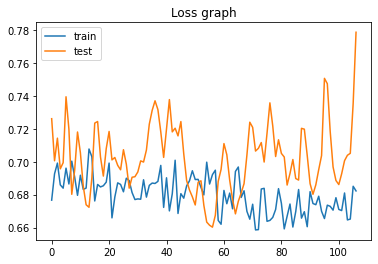

In [ ]:
#plot loss graph
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Loss graph")
plt.show()

In [ ]:
#reshape
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))

#predict values for test data
pred = model.predict(test_X)

#reshape again
test_X = test_X.reshape((test_X.shape[0], n_lag* n_features,))

3/3 [==============================] - 0s 4ms/step


In [ ]:
#change back from categorical
pred = np.argmax(pred, axis=1)

In [ ]:
#calculate accuracy
prices = pd.DataFrame()
prices["Actual"] = test_y
prices["Predicted"] = pred

prices["Correct"] = (prices["Actual"] - prices["Predicted"]) == 0
incorrect = prices.loc[prices['Correct'] == False]
incorrect_len = len(incorrect)
prices_len = len(prices)

print("Accuracy = ",((prices_len-incorrect_len)/prices_len))

Accuracy =  0.6865671641791045


In [ ]:
#Try printing the confusion matrix
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(prices["Actual"], prices["Predicted"])
print('Confusion Matrix : \n', CM)  

Confusion Matrix : 
 [[29  6]
 [15 17]]


Binary Logistic Regression

Refered to https://www.datascienceinstitute.net/blog/binary-logistic-regression-in-python-a-tutorial-part-1

In [ ]:
import pandas as pd
# read data 
# input_data = pd.read_csv("/content/drive/MyDrive/CS5344 Group9/BTC Price Pred Code/final_data_lag_days_1.csv", sep=",")
input_data = pd.read_csv("/content/drive/MyDrive/CS5344 Group9/Raw_Data/score.csv", sep=",")
# input_data["Pct_change"] = (input_data["Close"] > input_data["Close"].shift(1)).astype(int)
input_data.dropna(inplace=True)

In [ ]:
input_data.head(5)

,Unnamed: 0,Tweet_ID,Datetime,Account_Name,Text,sentiment_score
0,0,1584267915502977024,2022-10-23 19:37:59+00:00,VeronicaLake21,@BTC_for_Freedom Is this the best that you can...,0.6369
1,1,1584267914953502720,2022-10-23 19:37:59+00:00,EverleyHarriso1,"CNN desconecta Web3, NFT Project Vault - https...",0.0000
2,2,1584267912818270209,2022-10-23 19:37:59+00:00,TIPMayerMultple,"Oct 23, 2022: The current Mayer Multiple is 0....",0.0000
3,3,1584267907940294656,2022-10-23 19:37:58+00:00,cryptotrendin,Top 5 Mentions Updated Every 15 Minutes\n\n [...,0.2023
4,4,1584267900726435840,2022-10-23 19:37:56+00:00,0xEthereumYoda,#Ethereum price update: \n\n#ETH $1331.39 USD\...,0.0000


In [ ]:
input_data.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 10784 entries, 2018-08-30 11:00:00+00:00 to 2019-11-23 15:00:00+00:00
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           10784 non-null  float64
 1   Volume_(BTC)    10784 non-null  float64
 2   Weighted_Price  10784 non-null  float64
 3   neg_pol         10784 non-null  float64
 4   neu_pol         10784 non-null  float64
 5   pos_pol         10784 non-null  float64
 6   compound        10784 non-null  float64
 7   dt              10784 non-null  object 
 8   Tweet_vol       10784 non-null  float64
 9   Pct_change      10784 non-null  int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 926.8+ KB


In [ ]:
import statsmodels.formula.api as smf
model = smf.logit(formula = 'Pct_change ~ neg_pol + neu_pol + pos_pol', data = input_data).fit() 

         Current function value: 6.688227
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Pct_change   No. Observations:                10784
Model:                          Logit   Df Residuals:                    10780
Method:                           MLE   Df Model:                            3
Date:                Sun, 30 Oct 2022   Pseudo R-squ.:                  -8.650
Time:                        03:12:32   Log-Likelihood:                -72126.
converged:                      False   LL-Null:                       -7474.0
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.431e+05   2.02e+04     31.856      0.000    6.04e+05    6.83e+05
neg_pol    -6.432e+05   2.02e+04    -31.856      0.000   -6.83e+05   -6.04e+05
neu_pol    -6.431e+05   2.02e+04    -31.856      0.000   -6.83e+05   -6.04e+05
pos_pol    -6.432e+05   2.02e+04    -31.856      0.000   -6.83e+05   -6.04e+05
==============================================================================
"""

In [ ]:
from sklearn.metrics import confusion_matrix
predicted_values1 = model.predict()
threshold=0.5
predicted_class1=np.zeros(predicted_values1.shape)
predicted_class1[predicted_values1>threshold]=1
cm1 = confusion_matrix(input_data['Pct_change'],predicted_class1)
print('Confusion Matrix : \n', cm1)  
acc = (cm1[0][0]+cm1[1][1])/(cm1[0][0]+cm1[0][1]+cm1[1][1]+cm1[1][0])

Confusion Matrix : 
 [[2768 2553]
 [2842 2621]]


In [ ]:
print("Accuracy = ", acc)

Accuracy =  0.4997218100890208
